In [1]:
import cv2
import subprocess
import re
import numpy as np
import pandas as pd
from PyPDF2 import PdfFileReader
from IPython.display import Image
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

### PDF to CSV Block Based Algorithm

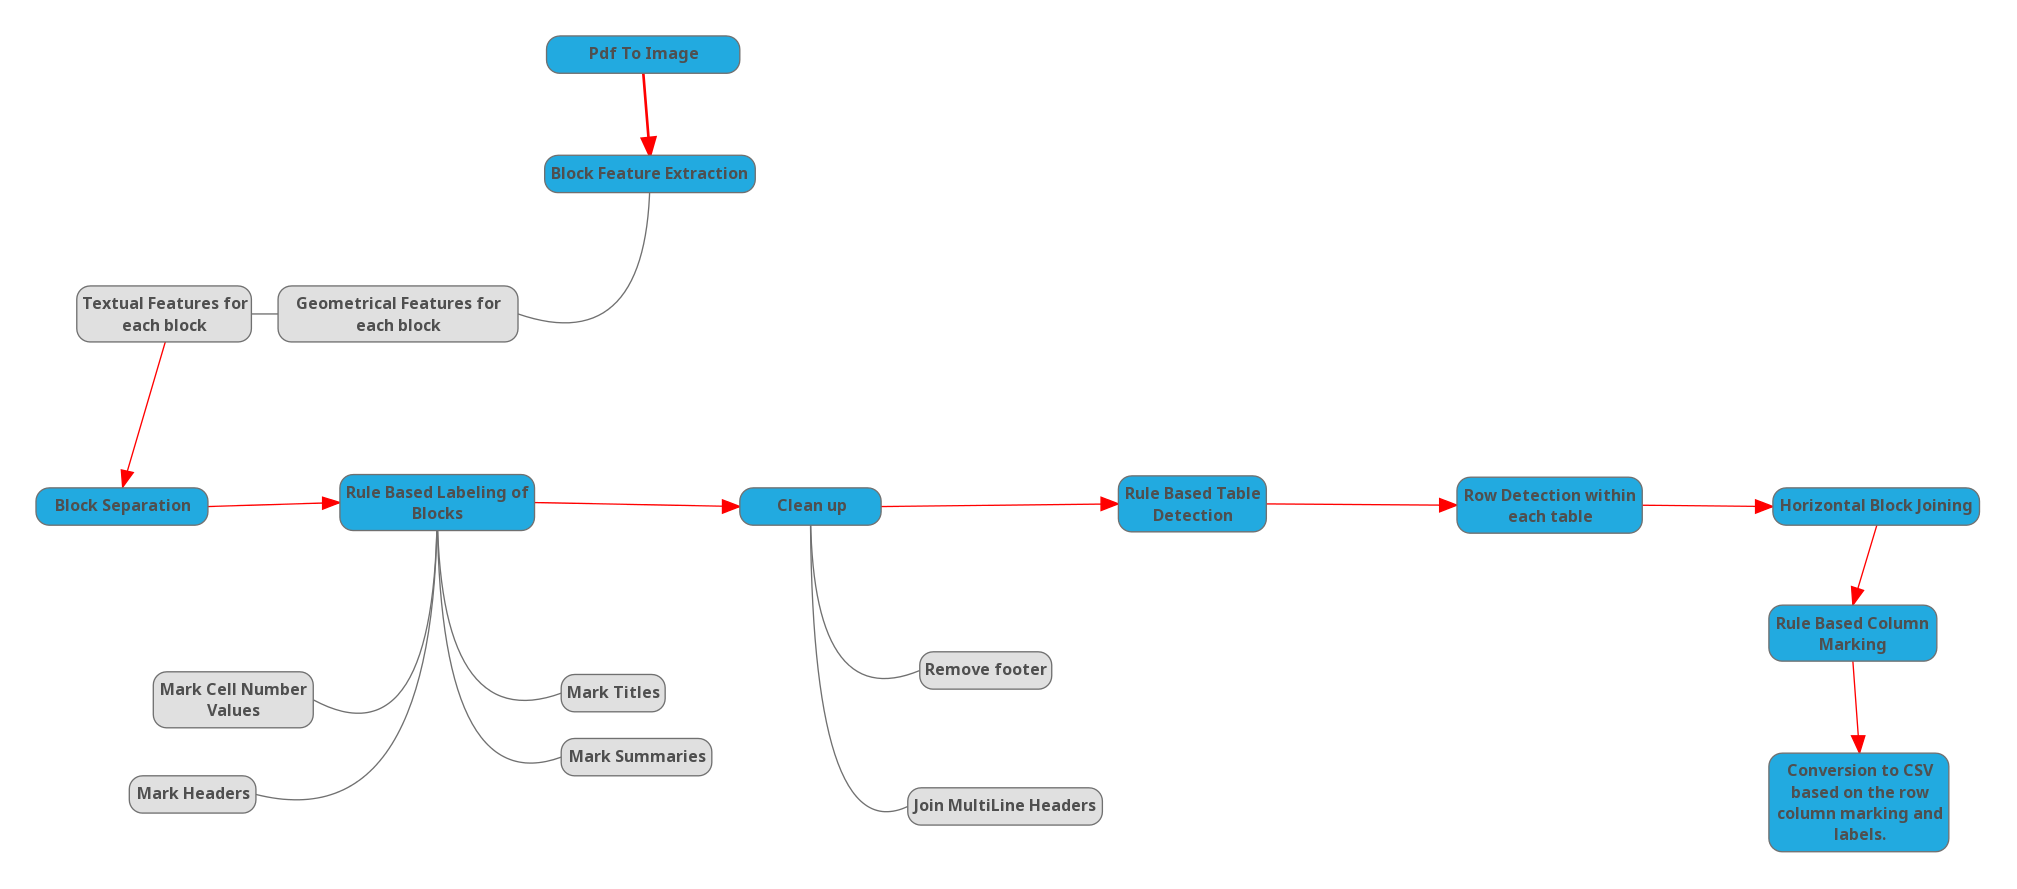

In [3]:
Image(filename='block_pdf_img_to_csv.png')

The Algorithm is a mix of Feature engineering/extraction and rule based labeling of blocks, where blocks are defined as group of texts separated by whitespace.

The first step to the algorithm is Block generation itself. We use an algorithm called [Run Length Smoothing Algorithm (RLSA)](#RLSA). 




After getting the blocks with generate two kinds of features : 

    - Geometrical features using `connectedComponentsWithStats` from [OpenCV](http://opencv.org/).
      This gives us features like: 
        - Left most point
        - Top most point
        - Height
        - Width etc.
    - Text Based Features, the text within each block is extracted using pdftotext from `poppler-0.57.0`
      https://poppler.freedesktop.org/. Using the text we generate textual features like:
        - Text Length
        - "is_text", defining whether the block contains numbers or text only.
        - "possible_row_merger", we detect if there is a possibilty of rows being merged in a block. 
          Its easily detected if the text has the new like character `\n`
        and more.
        

In [4]:
# Lets Load an image first.

def get_page_image_from_pdf(pdf, page_num, image_file_name):
    page_layout = pdf.getPage(page_num)['/MediaBox']
    command = "convert -density 300 '%s'[%s] '%s'" % (pdf_file_path,
                                                      page_num,
                                                      image_file_name)
    subprocess.check_output(command, shell=True)
    return cv2.imread(image_file_name, 0)

def plot_page(img):
    plt.figure(figsize=(30,20))
    plt.imshow(img, cmap='gray')

pdf_file_path = 'pdfs/west bengal/2017-18/2017_bp11_Demand Nos.1-5.pdf'
pdf = PdfFileReader(open(pdf_file_path, 'rb'))
page_layout = pdf.getPage(3)['/MediaBox']
if '/Rotate' in pdf.getPage(3) and pdf.getPage(3)['/Rotate'] == 90:
    page_width = float(page_layout[3])
    page_height = float(page_layout[2])
else:
    page_width = float(page_layout[2])
    page_height = float(page_layout[3])
img_page = get_page_image_from_pdf(pdf, 2, 'west_bengal_demand_1_5_page_1.png')
image_height, image_width = img_page.shape
horizontal_ratio = page_width / image_width
vertical_ratio = page_height / image_height


In [5]:
class ImageToBlocks(object):
    '''Convert Images to images with block like structures.
    
    Args:
        - img (obj:`numpy.Array`): A numpy array of the image.
        - block_threshold (tuple:(int, int)): A tuple containing threshold params
            namely vertical and horizontal for block generation.
    '''
    def __init__(self, img):
        self.img = img
        self.block_threshold = block_threshold
    
    def generate_blocks(self):
        ret,thresh1 = cv2.threshold(self.img, 0, 1, cv2.THRESH_BINARY_INV)
        img_iter = np.nditer(thresh1, flags=['multi_index'])
        C_vertical, C_horizontal = self.block_threshold
        temp_thresh = thresh1.copy()
        while not img_iter.finished:
            x, y = img_iter.multi_index
            x_threshold = x + C_horizontal
            y_threshold = y + C_vertical
            neg_x_threshold = x - C_horizontal
            neg_y_threshold = y - C_vertical
            if (thresh1[x:x_threshold, y:y_threshold].any() 
                or thresh1[x:x_threshold, y:neg_y_threshold].any()
                or thresh1[x:neg_x_threshold, y:y_threshold].any()
                or thresh1[x:neg_x_threshold, y:neg_y_threshold].any()):
                temp_thresh[x, y] = 1
            else:
                temp_thresh[x, y] = 0
            img_iter.iternext()
        return temp_thresh

    
class BlockGeometricalFeatureGenerator(ImageToBlocks):
    '''Extract geometrical feature for each block in a dataframe.
    
    Args:
        - img (obj:`numpy.Array`): A numpy array of the image.
        - block_threshold (tuple:(int, int)): A tuple containing threshold params
            namely vertical and horizontal for block generation.
    '''
    def __init__(self, img, block_threshold):
        super(BlockGeometricalFeatureGenerator, self).__init__(img, block_threshold)
        
    @staticmethod
    def __get_block_stats_df(stats, centroids):
        '''Convert stats from cv2.connectedComponentsWithStats to dataframe.
        
        Args:
            - stats (obj:`numpy.Array`): the stats generated from openCV
        
        Returns:
            A dataframe with stats
        '''
        stats_columns = ["left", "top", "width", "height", "area"]
        block_stats = pd.DataFrame(stats, columns=stats_columns)
        block_stats['centroid_x'], block_stats['centroid_y'] = centroids[:, 0], centroids[:, 1]
        # Ignore the label 0 since it is the background
        block_stats.drop(0, inplace=True)
        return block_stats
    
    def extract_block_stats(self):
        '''Extract Geometrical features from img with blocks.
        
        Returns:
            A dataframe with each row as block and its geom features.
        '''
        self.img_with_blocks = self.generate_blocks()
        _, _, stats, centroids = cv2.connectedComponentsWithStats(self.img_with_blocks)
        block_stats = self.__get_block_stats_df(stats, centroids)
        block_stats['right'] = block_stats.left + block_stats.width
        block_stats['bottom'] = block_stats.top + block_stats.height
        block_stats['pos'] = block_stats.index
        return block_stats
    
    @staticmethod
    def overlay_img_with_blocks(img, blocks):
        raise NotImplementedError('To be Implemented in Version 0.2')


class BlockTextualFeatureGenerator(BlockGeometricalFeatureGenerator):
    '''Extract Textual Features of each block.
    
    Args:
        - img (obj:`numpy.Array`): Matrix form of the image.
        - horizontal_ratio (float): ratio of page_width and image_width.
        - vertical_ratio (float): ratio of page_height and image_height.
        - page_num (int): Page number from where to read the text.
        - pdf_file_path (string): Path of the pdf file.
        - block_threshold (tuple:(int, int)): A tuple containing threshold params
            namely vertical and horizontal for block generation.
        - post_processors (list:[functions]): A list of functions that can process
            the blocks generated.
    '''
    TEXT_REGEX = '[a-zA-Z_]+'
    COMMA_SEP_REGEX = '^(-|[1-9])[0-9]*(,[0-9]).*$'
    
    def __init__(self, img, horizontal_ratio,
                 vertical_ratio, page_num, 
                 pdf_file_path, block_threshold,
                 post_processors=[]):
        #image params
        self.img = img
        self.block_threshold = block_threshold
        # these are required for scaling boundaries while reading text.
        self.horizontal_ratio = horizontal_ratio
        self.vertical_ratio = vertical_ratio
        # since we use an external command to extract text we need 
        # to have some pdf information also.
        self.pdf_file_path = pdf_file_path
        self.page_num = page_num
        # post processors
        self.post_processors = post_processors
    
    def get_text_from_pdf(self, x, y, w, h):
        cmd_ext = 'pdftotext'
        cmd_page_params = ' -f {0} -l {0}'.format(self.page_num + 1)
        cmd_tail = ' -x {0} -y {1} -W {2} -H {3} "{4}" -'.format(int(x), 
                                                                 int(y),
                                                                 int(w),
                                                                 int(h),
                                                                 self.pdf_file_path)
        command = cmd_ext + cmd_page_params + cmd_tail
        return subprocess.check_output(command, shell=True)
    
    def generate_text_data(self, row):
        '''Generate Text features for a given block.
        '''
        x = (row['left'] * self.horizontal_ratio)
        y = (row['top'] * self.vertical_ratio)
        width = (row['width'] * self.horizontal_ratio) + 5
        hieght = (row['height'] * self.vertical_ratio) + 5
        text = self.get_text_from_pdf(x, y, width, hieght)
        if len(text.strip().replace('-','')) < 1:
            row['text'] = text.strip().replace('-','')
        else:
            row['text'] = text.strip()
        row['text_length'] = len(row['text'])
        row['possible_row_merger'] = '\n' in row['text']
        text_matched = re.findall(self.TEXT_REGEX, row['text'])
        comma_sep_matcher = re.compile(self.COMMA_SEP_REGEX)
        if comma_sep_matcher.match(row['text'].replace('\n', ' ')):
            row['comma_separated_numbers_present'] = True
        else:
            row['comma_separated_numbers_present'] = False
        if len(text_matched) > 0:
            row['is_text'] = True
        else:
            row['is_text'] = False

        try:
            row['number'] = int(row['text'].replace(',',''))
        except:
            row['number'] = None
        return row
    
    def get_processed_blocks(self, block_stats):
        processed_block_stats = block_stats
        for func in self.post_processors:
            processed_block_stats = func(processed_block_stats)
        return processed_block_stats
    
    def generate(self):
        '''Extract text based features from each block.
        
        Returns:
            A Dataframe with each row as block and text based features.
        '''
        block_stats = self.extract_block_stats()
        block_stats_with_text_data = block_stats.apply(self.generate_text_data, axis=1)
        return self.get_processed_blocks(block_stats_with_text_data)


Post Getting our Features we do some cleaning up:
    
    - Remove Blocks that don't hold any information
    - Modify some of the blocks, seprate the blocks where there is a possbile merger detected. 


In [6]:
def filter_unwanted_blocks(block_features):
    # remove blank blocks
    filtered_block_features = block_features[block_features.text_length != 0]
    # remove footer
    return filtered_block_features[filtered_block_features.top < (block_features.top.max() * .95)]


def separate_blocks(block_features):
    processed_blocks = pd.DataFrame()
    for index, row in block_features.iterrows():
        splitted_row = []
        if row.possible_row_merger == True:
            for index, value in enumerate(row.text.split('\n')):
                new_row = {}
                for col in row.index:
                    new_row[col] = row[col]
                new_height = row.height // len(row.text.split('\n'))
                new_row['height'] = new_height
                new_row['top'] = row.top + (index * new_height)
                new_row['bottom'] = new_row['top'] + new_height
                new_row['text'] = value
                new_row['possible_row_merger'] = False
                splitted_row.append(new_row)
            processed_blocks = processed_blocks.append(splitted_row)
        else:
            processed_blocks = processed_blocks.append(row)
    return processed_blocks

In [7]:
# feature_extractor = BlockTextualFeatureGenerator(img_page, horizontal_ratio, vertical_ratio, 2, pdf_file_path, (20,25),
#                                                 [filter_unwanted_blocks, separate_blocks])
# block_features = feature_extractor.generate()

In [8]:
# block_features.head()

In [9]:
# block_features

Now that we have filtered our blocks we need to start labeling them as :-
    
    - number cells = blocks containing number values.
    - headers = Cell defining headers of the tables.
    - groupings = The left handside text information in each row.
    - summary = Summaries are combination of text and number values.
    - titles = Titles are the Huge Text separating the columns.
    
The most important labels are `number cells` and `titles`.
    
    - *titles* are used to separate out tables.
    - *number cells* are used to detect *headers* and *groupings*. Though it is easy to detect
      as these are blocks with numbers alone.
      
### NOTE:
All these rules are specific to West Bengal, they might vary a bit in different states.

In [10]:
class BlockLabeler(object):
    '''Label each block based on some rules.
    '''
    def __init__(self, block_features, post_processors=[]):
        self.block_features = block_features
        self.post_processors = post_processors
        if 'label' not in self.block_features.columns:
            self.block_features['label'] = None
    
    def mark_number_cells(self, row, features):
        if (row['comma_separated_numbers_present'] and row['is_text'] == 0) or (row['text'] == '...'):
            row['label'] = 'number_values'
        return row
    
    def mark_header(self, row, features):
        right, top = row.right, row.top
        numbers_below = features[(features.right.between(right - 10, right + 10)) & 
                                 (features.top > top) & 
                                 (features.label == 'number_values')]
        width_check = row['width'] < 1000
        if len(numbers_below) > 1 and row['label'] != 'number_values' and width_check:
            row['label'] = 'header'
        return row
    
    def mark_probable_headers(self, row, features):
        left, top = row['left'], row['top']
        right, bottom = row['right'], row['bottom']
#         features = features[features.table == row['table']]
        # labels in a radius of 15
        x_pos_axis = features[(features.left.between(right - 10, right + 15)) &
                              (features.label == 'header')]
        x_neg_axis = features[(features.right.between(left - 15, left + 10)) &
                              (features.label == 'header')]
        y_pos_axis = features[(features.bottom.between(top - 20, top + 10)) &
                              (features.label == 'header')]
        y_neg_axis = features[(features.top.between(bottom - 10, bottom + 15)) &
                              (features.label == 'header')]

        if (len(x_pos_axis) + len(x_neg_axis) + len(y_pos_axis) + len(y_neg_axis)) > 0:
            if pd.isnull(row['label']):
                row['label'] = 'header'
        return row

    
    def mark_grouping(self, row, features):
        left, right = row.left, row.right
        top, bottom = row.top, row.bottom
        top_left_check = features[(features.top.between(top - 10, top + 10)) &
                                  (features.left > left) &
                                  (features.label == 'number_values')
                                 ]
        bottom_left_check = features[(features.bottom.between(bottom - 10, bottom + 10)) &
                                  (features.left > left) &
                                  (features.label == 'number_values')
                                 ]
        if len(top_left_check.index) > 0 or len(bottom_left_check.index) > 0:
            if pd.isnull(row['label']):
                row['label'] = 'grouping'
        return row
    
    def mark_title(self, row):
        if (row.is_text == True and 
            row.centroid_x > 1200 and
            row.centroid_x < 1300 and
            pd.isnull(row.label)
           ):
            row['label'] = 'title'
        return row
    
    def mark_summary(self, row):
        if row['is_text'] == True:
            summaries = re.findall("^[A-z, a-z]*\sRs. [0-9|,]*$", row['text'])
            if len(summaries) > 0:
                row['label'] = 'cell_summary'
        return row

    def get_processed_blocks(self, block_features):
        processed_block_feature = block_features
        for func in self.post_processors:
            processed_block_feature = func(processed_block_feature)
        return processed_block_feature
    
    def label(self):
        block_features = self.block_features.apply(self.mark_number_cells, axis=1, args=[self.block_features])
        block_features = block_features.apply(self.mark_header, axis=1, args=[block_features])
        block_features = block_features.apply(self.mark_grouping, axis=1, args=[block_features])
        block_features = block_features.apply(self.mark_title, axis=1)
        block_features = block_features.apply(self.mark_probable_headers, axis=1, args=[block_features])
        return self.get_processed_blocks(block_features.apply(self.mark_summary, axis=1))


We need to separate out tables because in some pages there are 2 tables, we can use titles to separate out tables.
Also the headers need to be combined into 1 label for easy later processing to convert into csv.

In [26]:
def check_table_separators(separators, features):
    '''
    For each table separator there should be `number_value` blocks above and 
    below it.
    '''
    filtered_separators = []
    if len(separators) > 1:
        #TODO: Handle when separators are more then 1. .i.e. more then 1 table detected.
        return separators
    
    for separator in separators:
        numbers_above = len(features[(features.top < separator) & (features.label == 'number_values')])
        numbers_below = len(features[(features.top > separator) & (features.label == 'number_values')])
        if numbers_above > 0 and numbers_below > 0:
            filtered_separators.append(separator)
    return filtered_separators

def mark_tables_using_titles(features):
    titles = features[features.label == 'title']
    titles['next_diff'] = titles.top - titles.top.shift(1)
    seperators = titles[titles.next_diff > titles.next_diff.mean()]['top'].tolist()
    begin, end = features.top.min(), features.bottom.max()
    seperators = [begin] + check_table_separators(seperators, features) + [end]
    features['table'] = None
    for index, sep in enumerate(seperators):
        if index > 0:
            table_start, table_end = seperators[index - 1], sep
            features.loc[
                    features['top'].between(table_start, table_end),
                    'table'
                ] = index
    return features


def combine_headers(features):
    """
    1. Combine Blocks based on their horizontal distance.
    """
    processed_features = pd.DataFrame()
    skip_pos = []
    for index, row in features.iterrows():
        if row['pos'] not in skip_pos:
            nearby_header = features[(features.left.between(row['left'] - row['width'], row['right'])) &
                                     (features.index != index) &
                                     (features.label == 'header') &
                                     (features.table == row['table'])].sort_values('top', ascending=True)
            if len(nearby_header) > 0 and row['label'] == 'header':
                # if mergable create a common label and push the `pos` of
                # the row that is being merged into skip_pos
                row['text'] = row['text'] + ' ' + ' '.join(nearby_header.text.tolist())
                row['text'] = row['text'].replace('\n', ' ')
                row['width'] = max([row['width']] + nearby_header.width.tolist())
                row['height'] = row['height'] + nearby_header.height.sum()
                row['left'] = min(row['left'], nearby_header.left.min())
                row['right'] = row['left'] + row['width']
                row['bottom'] = row['top'] + row['height']
                skip_pos.extend(nearby_header.pos.tolist())
            processed_features = processed_features.append(row)
    return processed_features

def combine_horizontal(block_features):
    """
    1. Combine Blocks based on their horizontal distance.
    """
    processed_features = pd.DataFrame()
    skip_pos = []
    for index, row in block_features.iterrows():
        if row['pos'] not in skip_pos:
            nearby_labels = block_features[(block_features.left.between(row['left'] - 5, row['right'] + 5)) &
                                           (block_features.top.between(row['top'] -5, row['top'] + 5)) &
                                           (block_features.pos != row['pos'])]
            if len(nearby_labels) > 0 and row['label'] not in ['header', 'number_values']:
                # if mergable create a common label and push the `pos` of
                # the row that is being merged into skip_pos
                row['text'] = row['text'] + ' '.join(nearby_labels.text.tolist())
                row['width'] = row['width'] + nearby_labels.width.sum()
                row['right'] = row['left'] + row['width']
                skip_pos.extend(nearby_labels.pos.tolist())
            processed_features = processed_features.append(row)
    return processed_features

In [12]:
# block_features_with_labels = BlockLabeler(block_features, post_processors=[mark_tables_using_titles, 
#                                                                            combine_headers,
#                                                                            combine_horizontal]).label()

In [13]:
# block_features_with_labels[block_features_with_labels['label'] == 'header']

In [14]:
# block_features_with_labels.head()

There would still be some unmarked blocks because some of the blocks don't really lie adjacent to any number cells and some are higher level grouping, which is not required to be marked at the moment.

In [15]:
# block_features_with_labels[pd.isnull(block_features_with_labels.label)]

So now we have a lot of information about what each block is with respect to a table, and to finally convert it into and csv we need to draw the columns and rows so that we can understand the layout of the table and store it as csv.

In [185]:
class BlocksToCSV(object):
    '''Convert blocks with labels to a csv.
    '''
    DEFAULT_HEADERS = 'Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.;'
    
    def __init__(self, img, block_features, page_num):
        self.img = img
        self.block_features = block_features
        self.page_num = page_num
    
    def find_rows(self, block_features):
        """
        Figure out the points where rows start and end.

        1. Headers would be the starting point. Bottom of the headers
        2. Each cell value will be separated by a row.
        """
        rows = []
        rows.extend(block_features[block_features['label'] == 'header'].aggregate({'top': min, 'bottom': max}).values.flatten())
        rows.extend(block_features[block_features['label'] == 'number_values']['bottom'].unique())
        return rows
    
    def get_marked_rows(self, block_features):
        for table in block_features.table.unique():
            table_block_features = block_features[block_features.table == table]
            rows = self.find_rows(table_block_features)
            combined_rows = sorted(rows + table_block_features[pd.isnull(table_block_features.label)].bottom.unique().tolist())
            for index, row_start in enumerate(combined_rows[:-1]):
                row_end = combined_rows[index + 1]
                block_features.loc[((block_features.top.between(row_start, row_end)) & 
                                    (block_features.table == table) &
                                    (block_features.label != 'title')), 'row_index'] = index
        return block_features
    
    def filter_possible_cols(self, cols, table_start, table_end):
        columns_df = pd.DataFrame({'cols': cols})
        columns_df['dark_pixel_count'] = columns_df.cols.apply(lambda x: (self.img[table_start:table_end, int(x)] < 255).sum())
        columns_df['next_diff'] = columns_df.cols.shift(-1) - columns_df.cols
        columns_df['next_diff'] = columns_df['next_diff'].fillna(1000)
        filtered_columns_df = columns_df[columns_df['dark_pixel_count'] < 200]
        return filtered_columns_df[filtered_columns_df.next_diff > 150].cols.tolist()
    
    def mark_cols(self, features, table_cols, table):
        print(table_cols)
        for index, col_start in enumerate(table_cols[:-1]):
            col_end = table_cols[index + 1]
            row_index_count = features[(features.left.between(col_start, col_end) & 
                                       (features.table == table))]['row_index'].value_counts()
            overlaps = row_index_count[row_index_count > 1].index
            if len(overlaps) > 0:
                overlapping_features = features[(features.left.between(col_start, col_end) & 
                                                (features.table == table) &
                                                (features.row_index.isin(overlaps)))]
                overlapping_separating_cols = overlapping_features.groupby('row_index')['right'].min().unique().tolist()
                new_table_cols = table_cols[:index + 1] + overlapping_separating_cols + table_cols[index + 1:]
                new_table_cols = [int(x) for x in new_table_cols]
                table_start = min(new_table_cols)
                table_end = max(new_table_cols) + 1
                cols = self.filter_possible_cols(new_table_cols, table_start, table_end)
                if table_cols != cols:
                    return self.mark_cols(features, cols, table)
            features.loc[(features.left.between(col_start, col_end) & 
                         (features.table == table)), 'col_index'] = index
        return features
    
    def get_marked_cols(self, features_with_rows):
        for table in features_with_rows.table.unique():
            table_rows = features_with_rows[features_with_rows.table == table]
            if len(table_rows.row_index.dropna()) == 0:
                 continue
            row_with_max_cols = table_rows.groupby(['row_index']).apply(lambda x: len(sorted(x['right'].unique()))).idxmax()
            possible_cols = table_rows.groupby(['row_index']).apply(lambda x: sorted(x['right'].unique())).loc[row_with_max_cols]
            v_table_start, v_table_end = table_rows.agg({'top':min, 'bottom': max}).values.flatten()
            h_table_start, h_table_end = table_rows.left.min(), table_rows.right.max()
            cols = self.filter_possible_cols(possible_cols, int(v_table_start), int(v_table_end))
            table_cols = [h_table_start] + sorted(cols)
            features_with_rows = self.mark_cols(features_with_rows, table_cols, table)
        return features_with_rows
    
    def get_features_with_rows_and_cols(self):
        block_features_with_rows = self.get_marked_rows(self.block_features)
        return self.get_marked_cols(block_features_with_rows)
    
    def write_to_csv(self):
        block_features = self.get_features_with_rows_and_cols()
        for table_no in block_features.table.unique():
            table_features = block_features[block_features.table == table_no]
            title = '_'.join(table_features[table_features.label == 'title']['text'].tolist()).replace(' ', '_')
            print(title)
            print('-' * 10)
            if 'number_values' in table_features.label.unique():
                filename = '{0}_{1}.csv'.format(self.page_num, table_no)
                max_col = len(table_features.col_index.unique())
                print(max_col, len(self.DEFAULT_HEADERS.split(';')), max_col - len(self.DEFAULT_HEADERS.split(';')))
                with open(filename, 'w') as csv_file:
                    # for each row write a line
                    if 'header' not in table_features.label.unique():
                        number_of_default_headers = len(self.DEFAULT_HEADERS.split(';')) - 1
                        headers_row = ';' * (max_col - number_of_default_headers)
                        headers_row += self.DEFAULT_HEADERS
                        csv_file.write(headers_row)
                        csv_file.write('\n')
                    for _, group in table_features.sort_values('top').groupby('row_index'):
                        row = ''
                        for column_index in range(max_col + 1):
                            value = group[group.col_index == column_index]
                            if len(value.index) == 0:
                                row += ' ;'
                            else:
                                row += value.text.iloc[0] + ';'
                        csv_file.write(row)
                        csv_file.write('\n')
                        print(row)

In [160]:
# BlocksToCSV(img_page, block_features_with_labels, 'sample').write_to_csv()

### Test

Lets run the code for multiple results and improve the rules.

In [186]:
pdf_file_path = 'pdfs/west bengal/2017-18/2017_bp11_Demand Nos.1-5.pdf'

def run(page_num, pdf_file_path):
    pdf = PdfFileReader(open(pdf_file_path, 'rb'))
    page_layout = pdf.getPage(page_num)['/MediaBox']
    if '/Rotate' in pdf.getPage(page_num) and pdf.getPage(3)['/Rotate'] == 90:
        page_width = float(page_layout[3])
        page_height = float(page_layout[2])
    else:
        page_width = float(page_layout[2])
        page_height = float(page_layout[3])
    img_page = get_page_image_from_pdf(pdf, page_num, 'west_bengal_demand_1_5_page_1.png')
    image_height, image_width = img_page.shape
    horizontal_ratio = page_width / image_width
    vertical_ratio = page_height / image_height
    feature_extractor = BlockTextualFeatureGenerator(img_page, horizontal_ratio, 
                                                     vertical_ratio, 2, pdf_file_path, (20,25),
                                                    [filter_unwanted_blocks, separate_blocks])
    block_features = feature_extractor.generate()
    block_features_with_labels = BlockLabeler(block_features, post_processors=[mark_tables_using_titles, 
                                                                           combine_headers,
                                                                           combine_horizontal]).label()
    BlocksToCSV(img_page, block_features_with_labels).write_to_csv()

for page_num in range(7, 133):
    pdf = PdfFileReader(open(pdf_file_path, 'rb'))
    page_layout = pdf.getPage(page_num)['/MediaBox']
    if '/Rotate' in pdf.getPage(page_num) and pdf.getPage(page_num)['/Rotate'] == 90:
        page_width = float(page_layout[3])
        page_height = float(page_layout[2])
    else:
        page_width = float(page_layout[2])
        page_height = float(page_layout[3])
    img_page = get_page_image_from_pdf(pdf, page_num, 'west_bengal_demand_1_5_page_1.png')
    image_height, image_width = img_page.shape
    horizontal_ratio = page_width / image_width
    vertical_ratio = page_height / image_height
    feature_extractor = BlockTextualFeatureGenerator(img_page, horizontal_ratio, 
                                                     vertical_ratio, page_num, pdf_file_path, (27,20),
                                                    [filter_unwanted_blocks, separate_blocks])
    block_features = feature_extractor.generate()
    block_features_with_labels = BlockLabeler(block_features, post_processors=[mark_tables_using_titles, 
                                                                           combine_headers,
                                                                           combine_horizontal]).label()
    BlocksToCSV(img_page, block_features_with_labels, page_num).write_to_csv()
    print(page_num)
    print('s'*12)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:19]


[136.0, 1161.0, 1449.0, 1739.0, 2028.0, 2317.0]
REVENUE_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_2011_DETAILED_ACCOUNT_NO._2011_-_DEDUCT_RECOVERIES_IN_REDUCTION_OF_EXPENDITURE
----------
(5, 5, 0)
 ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
Total - 2011-02-103-NP-002;...;5,000;5,000;5,000; ;
003- Contribution too the West Bengal Branch of the; ; ; ; ; ;
Commonwealth Parliamentary Association [LA]; ; ; ; ; ;
32- Contribution;6,78,317;15,00,000;15,00,000;15,00,000; ;
Total - 2011-02-103-NP-003;6,78,317;15,00,000;15,00,000;15,00,000; ;
004- Contribution towards Presiding Officers Conference [LA]; ; ; ; ; ;
32- Contribution;3,00,000;3,10,000;3,10,000;3,10,000; ;
Total - 2011-02-103-NP-004;3,00,000;3,10,000;3,10,000;3,10,000; ;
005- Celebration of Platinum Jubilee of the West Bengal; ; ; ; ; ;
Legislative Assembly [LA]; ; ; ; ; ;
13- Office Expenses; ; ; ; ; ;
04-Other Office Expenses;6,31,712;8,00,000;8,00,000;5

[136.0, 762.0, 1449.0, 1738.0, 2026.0, 2315.0]
[136, 762, 1163, 1449, 1738, 2026, 2315]
CAPITAL_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_4216_DETAILED_ACCOUNT_NO._4216-01-106_-_GENERAL_POOL_ACCOMMODATION_DETAILED_ACCOUNT_NO._4216-01-106_-_GENERAL_POOL_ACCOMMODATION_.
----------
(6, 5, 1)
 ; ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
01 - GOVERNMENT RESIDENTIAL BUILDINGS; ; ; ; ; ; ;
106- General Pool Accommodation; ; ; ; ; ; ;
SP-State Plan (Annual Plan & XII th Plan); ; ; ; ; ; ;
011- Administration of Justice -Construction of Multistoried; ; ; ; ; ; ;
Building at High Court Tram Terminus for accommodation; ; ; ; ; ; ;
of M.L.A.s and Group D Staff of W. B. Legislative; ; ; ; ; ; ;
Assembly [LA]; ; ; ; ; ; ;
53- Major Works / Land and Buildings; ;...;...;...;...; ;
 ;Total - 4216-01-106;...;...;...;...; ;
 ;Voted;...;...;...;...; ;
 ;Charged;...;...;...;...; ;
14
ssssssssssss
[135.0, 938.0, 1767.0, 2042.0, 2

[135.0, 1162.0, 1450.0, 1739.0, 2028.0, 2317.0]
[136.0, 343.0, 1163.0, 1450.0, 1740.0, 2029.0, 2318.0]
REVENUE_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_2012
----------
(5, 5, 0)
 ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
Total - 2012-03-102-NP - Non Plan;13,64,984;15,75,000;15,75,000;17,17,000; ;
Total - 2012-03-102;13,64,984;15,75,000;15,75,000;17,17,000; ;
Voted;...;...;...;...; ;
Charged;13,64,984;15,75,000;15,75,000;17,17,000; ;
.; ; ; ; ; ;
DETAILED_ACCOUNT_NO._2012-03-103_-_HOUSEHOLD_ESTABLISHMENT
----------
(6, 5, 1)
03 - GOVERNOR; ; ; ; ; ; ;
103- Household Establishment; ; ; ; ; ; ;
NP-Non Plan; ; ; ; ; ; ;
001- Governors (Household) Secretariat [GS]; ; ; ; ; ; ;
01- Salaries; ; ; ; ; ; ;
01-Pay;Charged;1,48,89,293;1,64,26,000;1,53,36,000;1,57,96,000; ;
14-Grade Pay;Charged;32,98,873;33,79,000;38,34,000;39,49,000; ;
02-Dearness Allowance;Charged;1,17,06,504;1,67,78,000;1,47,28,000;1,71,13,000; ;
03

[138.0, 454.0, 1163.0, 1449.0, 1740.0, 2029.0, 2318.0]
[136.0, 377.0, 1451.0, 1740.0, 2029.0, 2318.0]
[136, 377, 1162, 1451, 1740, 2029, 2318]
REVENUE_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_2012
----------
(6, 5, 1)
 ; ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
800- Other Expenditure; ; ; ; ; ; ;
NP-Non Plan; ; ; ; ; ; ;
001- Other Expenditure [GS]; ; ; ; ; ; ;
50- Other Charges;Charged;...;33,000;33,000;33,000; ;
51- Motor Vehicles;Charged;...;17,33,000;17,33,000;17,33,000; ;
 ;Total - 2012-03-800-NP-001;...;17,66,000;17,66,000;17,66,000; ;
002- Furnishing of Raj Bhawans at Kolkata and Darjeeling [GS]; ; ; ; ; ; ;
50- Other Charges;Charged;31,56,653;34,65,000;34,65,000;34,65,000; ;
 ;Total - 2012-03-800-NP-002;31,56,653;34,65,000;34,65,000;34,65,000; ;
 ;Total - 2012-03-800-NP - Non Plan;31,56,653;52,31,000;52,31,000;52,31,000; ;
 ;Total - 2012-03-800;31,56,653;52,31,000;52,31,000;52,31,000; ;
 ;Voted;...

[135.0, 1160.0, 1450.0, 1739.0, 2028.0, 2317.0]
[135.0, 454.0, 1450.0, 1739.0, 2028.0, 2317.0]
[135, 454, 1163, 1450, 1739, 2028, 2317]
[135.0, 707.0, 1449.0, 1739.0, 2028.0, 2317.0]
[135, 707, 1163, 1449, 1739, 2028, 2317]
[135.0, 449.0]
REVENUE_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_2013
----------
(5, 5, 0)
 ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
Total - 2013-00-101;37,96,050;90,46,000;99,56,000;1,03,04,000; ;
Voted;37,96,050;90,46,000;99,56,000;1,03,04,000; ;
Charged;...;...;...;...; ;
.; ; ; ; ; ;
DETAILED_ACCOUNT_NO._2013-00-102_-_SUMPTUARY_AND_OTHER_ALLOWANCES_DETAILED_ACCOUNT_NO._2013-00-102_-_SUMPTUARY_AND_OTHER_ALLOWANCES_.
----------
(6, 5, 1)
NP-Non Plan; ; ; ; ; ; ;
001- Sumptuary and Other Allowances [CL]; ; ; ; ; ; ;
50- Other Charges; ;1,71,06,000;2,72,50,000;2,72,50,000;2,97,03,000; ;
 ;Total - 2013-00-102-NP - Non Plan;1,71,06,000;2,72,50,000;2,72,50,000;2,97,03,000; ;
 ;Total - 2013-

[135.0, 481.0, 1449.0, 1739.0, 2028.0, 2317.0]
[135, 481, 1163, 1449, 1739, 2028, 2317]
REVENUE_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_2401_DETAILED_ACCOUNT_NO._2401-00-800_-_OTHER_EXPENDITURE_DETAILED_ACCOUNT_NO._2401-00-800_-_OTHER_EXPENDITURE_.
----------
(6, 5, 1)
 ; ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
800- Other Expenditure; ; ; ; ; ; ;
SP-State Plan (Annual Plan & XII th Plan); ; ; ; ; ; ;
009- Additional Central Assistance Scheme under Rastriya Krishi; ; ; ; ; ; ;
Vikash Yojana (Central Share) (RKVY) [AM]; ; ; ; ; ; ;
31- Grants-in-aid-GENERAL; ; ; ; ; ; ;
02-Other Grants; ;13,26,12,475;28,00,00,000;28,00,00,000;38,00,00,000; ;
77- Computerisation; ;...;...;...;...; ;
 ;Total - 2401-00-800-SP-009;13,26,12,475;28,00,00,000;28,00,00,000;38,00,00,000; ;
024- Scheme under Rastriya Krishi Vikash Yojana (State Share); ; ; ; ; ; ;
(RKVY) (RKVY) [AM]; ; ; ; ; ; ;
31- Grants-in-aid-GENERAL; ; ; ; ; ; 

[135.0, 470.0, 1449.0, 1738.0, 2026.0, 2315.0]
[135, 470, 1163, 1449, 1738]
[136.0, 343.0, 1450.0, 1739.0, 2028.0, 2317.0]
[136, 343, 1160, 1450, 1739, 2028, 2317]
REVENUE_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_2408
----------
(5, 5, 0)
 ; ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.; ; ;
51- Motor Vehicles; ;...;...; ; ;
52- Machinery and Equipment/Tools and Plants; ;...;...; ; ;
77- Computerisation; ;...;...; ; ;
98- Training; ;...;...; ; ;
Total - 2408-02-001-SP - State Plan (Annual Plan & XII th Plan); ;...;10,00,000; ; ;
 ;Total - 2408-02-001;2,49,42,067;3,16,87,000; ; ;
 ;Voted;2,49,42,067;3,16,87,000; ; ;
 ;Charged;...;...; ; ;
.; ; ; ; ; ;
DETAILED_ACCOUNT_NO._2408-02-003_-_TRAINING
----------
(6, 5, 1)
02 - STORAGE AND WAREHOUSING; ; ; ; ; ; ;
003- Training; ; ; ; ; ; ;
NP-Non Plan; ; ; ; ; ; ;
001- Training-cum-Production Centres for Fruit Products [AM]; ; ; ; ; ; ;
01- Salaries; ; ; ; ; ; ;
01-Pay; ;4,11,980;3,16,000;4,24,000;4,37,000; ;
14-Grade Pay; ;93,600;70

[136.0, 1450.0, 1738.0, 2027.0, 2316.0]
[136, 507, 1161, 1450, 1738, 2027, 2316]
REVENUE_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_2408
----------
(6, 5, 1)
01-Others; ;Actuals, 2015-2016 Rs. -60;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
02-W.B.H.S. 2008; ;...;...;...;...; ;
011-Strengthening and Supervision of Cold Storages [AM]; ; ; ; ; ; ;
70-Deduct Recoveries; ; ; ; ; ; ;
01-Others; ; ;...;...;...; ;
02-W.B.H.S. 2008; ;...;...;...;...; ;
 ;Total - 800 - Deduct - Recoveries;-8,61,432;...;...;...; ;
911- Deduct Recoveries of Overpayments; ; ; ; ; ; ;
NP-Non Plan; ; ; ; ; ; ;
002-Scheme for processing and preservation of fruits and; ; ; ; ; ; ;
Vegetables [AM]; ; ; ; ; ; ;
70-Deduct Recoveries; ; ; ; ; ; ;
01-Others; ;...;...;...;...; ;
02-W.B.H.S. 2008; ;...;...;...;...; ;
SP-State Plan (Annual Plan & XII th Plan); ; ; ; ; ; ;
001-Deduct-Recoveries of Overpayments [AM]; ; ; ; ; ; ;
70-Deduct Recoveries; ; ; ; ; ; ;
01-Others; ;..

[138.0, 343.0, 1450.0, 1739.0, 2028.0, 2317.0]
[138, 343, 1162, 1450, 1739, 2028, 2317]
REVENUE_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_2435
----------
(6, 5, 1)
 ; ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
01- Salaries; ; ; ; ; ; ;
01-Pay; ;33,62,392;37,50,000;34,63,000;35,67,000; ;
14-Grade Pay; ;9,26,840;9,84,000;8,66,000;8,92,000; ;
02-Dearness Allowance; ;28,24,440;40,24,000;33,26,000;38,65,000; ;
03-House Rent Allowance; ;4,94,125;7,10,000;6,06,000;6,24,000; ;
04-Ad hoc Bonus; ;12,800;47,000;47,000;49,000; ;
05-Interim Relief; ;...;2,63,000;2,42,000;3,57,000; ;
07-Other Allowances; ;1,650;46,000;20,000;22,000; ;
11-Compensatory Allowance; ;...;5,000;5,000;5,000; ;
12-Medical Allowances; ;14,980;21,000;21,000;22,000; ;
13-Dearness Pay; ;...;...;...;...; ;
 ;Total - 2435-01-101-NP-003-01;76,37,227;98,50,000;85,96,000;94,03,000; ;
02- Wages; ;2,18,374;2,68,000;6,50,000;7,00,000; ;
07- Medical Reimbursem

[135.0, 525.0, 1449.0, 1738.0, 2026.0, 2315.0]
[135, 525, 1163, 1449, 1738, 2315]
[135, 525, 1163, 1449, 1738, 2028, 2315]
[136.0, 454.0, 1450.0, 1739.0, 2028.0, 2317.0]
[136, 454, 1161, 1450, 1739, 2028, 2317]
REVENUE_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_2435
----------
(6, 5, 1)
 ; ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
33- Subsidies; ; ; ; ; ; ;
05-Other Subsidies; ;...;...;...;...; ;
Total - 2435-01-190-SP - State Plan (Annual Plan & XII th Plan); ;1,42,40,000;2,00,00,000;1,99,98,000;3,50,00,000; ;
 ;Total - 2435-01-190;1,42,40,000;2,00,00,000;1,99,98,000;3,50,00,000; ;
 ;Voted;1,42,40,000;2,00,00,000;1,99,98,000;3,50,00,000; ;
 ;Charged;...;...;...;...; ;
.; ; ; ; ; ; ;
DETAILED_ACCOUNT_NO._2435-01-789_-_SPECIAL_COMPONENT_PLAN_FOR_SCHEDULED_CASTES
----------
(6, 5, 1)
01 - MARKETING AND QUALITY CONTROL; ; ; ; ; ; ;
789- Special Component Plan for Scheduled Castes; ; ; ; ; ; ;
SP-State Plan (Annu

[137.0, 377.0, 1449.0, 1740.0, 2026.0, 2315.0]
[137, 377, 1161, 1449, 1740, 2026, 2315]
REVENUE_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_2435
----------
(6, 5, 1)
 ; ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
NP-Non Plan; ; ; ; ; ; ;
001-Marketing Department [AM]; ; ; ; ; ; ;
70-Deduct Recoveries; ; ; ; ; ; ;
01-Others; ;...;-1,19,000;...;...; ;
02-W.B.H.S. 2008; ;...;...;...;...; ;
002-Strengthening of staff of the Marketing Branch of; ; ; ; ; ; ;
Directoratate of Agriculture [AM] [AM]; ; ; ; ; ; ;
70-Deduct Recoveries; ; ; ; ; ; ;
01-Others; ;-13,400;...;-13,000;-13,000; ;
02-W.B.H.S. 2008; ;...;...;...;...; ;
015-Receipt of over payments [AM]; ; ; ; ; ; ;
70-Deduct Recoveries; ; ; ; ; ; ;
01-Others; ;...;...;...;...; ;
SP-State Plan (Annual Plan & XII th Plan); ; ; ; ; ; ;
004-Subsidy for Marketing of Non-perishable Agriculture; ; ; ; ; ; ;
Products [AM] [AM]; ; ; ; ; ; ;
70-Deduct Recoveries; ; ; ; ; ; ;

[135.0, 938.0, 1767.0, 2039.0, 2317.0]
[135.0, 926.0, 1492.0, 1767.0, 2042.0, 2317.0]
[135, 926, 1217, 1492, 1767, 2042, 2317]
CAPITAL_EXPENDITURE_DEMAND_No._04_Agricultural_Marketing_Department_C-Capital_Account_of_Economic_Services_-_(a)_Capital_Account_of_Agriculture_and_Allied_Activities_Head_of_Account_:_4435_-_Capital_Outlay_on_Other_Agricultural_Programmes_Charged_Rs._Nil
----------
(4, 5, -1)
 ;Voted Rs.;Charged Rs.;Total Rs.; ;
Gross Expenditure;19,60,00,000;...;19,60,00,000; ;
Deduct - Recoveries;...;...;...; ;
Net Expenditure;19,60,00,000;...;19,60,00,000; ;
CAPITAL_EXPENDITURE_ABSTRACT_ACCOUNT
----------
(6, 5, 1)
 ; ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
01 - MARKETING AND QUALITY CONTROL; ; ; ; ; ; ;
101- Marketing Facilities; ; ; ; ; ; ;
SP-State Plan (Annual Plan & XII th Plan); ;5,96,24,143;67,50,00,000;11,62,25,000;9,00,00,000; ;
CS-Centrally Sponsored (New Schemes); ;...;...;...;...; ;


[138.0, 1161.0, 1450.0, 1738.0, 2026.0, 2315.0]
[136.0, 377.0, 1449.0, 1738.0, 2026.0, 2315.0]
CAPITAL_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_4435
----------
(5, 5, 0)
 ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
Total - 4435-01-796-SP-005;42,42,000;...;...;...; ;
Total - 4435-01-796-SP - State Plan (Annual Plan & XII th Plan);95,58,907;11,85,00,000;2,12,50,000;4,60,00,000; ;
CS-Centrally Sponsored (New Schemes); ; ; ; ; ;
001- Annual Macro Management Mode Work Plan on Agriculture; ; ; ; ; ;
Marketing and Development Work [AM]; ; ; ; ; ;
50- Other Charges;...;...;...;...; ;
60- Other Capital Expenditure;...;...;...;...; ;
Total - 4435-01-796;95,58,907;11,85,00,000;2,12,50,000;4,60,00,000; ;
Voted;95,58,907;11,85,00,000;2,12,50,000;4,60,00,000; ;
Charged;...;...;...;...; ;
DETAILED_ACCOUNT_NO._4435_-_DEDUCT_RECOVERIES_IN_REDUCTION_OF_EXPENDITURE
----------
(5, 5, 0)
101- Marketing Facilities; ; ; ; ; ;
SP-St

[135.0, 938.0, 1767.0, 2039.0, 2316.0]
[136.0, 953.0, 1492.0, 1766.0, 2041.0, 2316.0]
[136, 953, 1219, 1492, 1766, 2041, 2316]
LOAN_EXPENDITURE_DEMAND_No._04_Agricultural_Marketing_Department_F-Loans_and_Advances_-_Head_of_Account_:_6435_-_Loans_For_Other_Agricultural_Programmes_Charged_Rs._Nil
----------
(4, 5, -1)
Voted Rs. Nil; ;Total Rs. Nil Charged Rs. Total Rs.; ; ;
Gross Expenditure;Voted Rs.;...;...; ;
Deduct - Recoveries;...;...;...; ;
Net Expenditure;...;...;...; ;
 ;LOAN EXPENDITURE; ; ; ;
ABSTRACT_ACCOUNT
----------
(6, 5, 1)
01 - MARKETING AND QUALITY CONTROL; ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
101- Marketing Facilities; ; ; ; ; ; ;
SP-State Plan (Annual Plan & XII th Plan); ;27,00,00,000;...;...;...; ;
 ;Total - 101;27,00,00,000;...;...;...; ;
Grand Total - Gross; ;27,00,00,000;...;...;...; ;
 ;Voted;27,00,00,000;...;...;...; ;
 ;Charged;...;...;...;...; ;
SP - State Plan (Annual Plan & 

[136.0, 1162.0, 1450.0, 1739.0, 2028.0, 2317.0]
[136, 730, 1162, 1450, 1739, 2028, 2317]
[136, 730, 979, 1162, 1450, 1739, 2028, 2317]
REVENUE_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_2235
----------
(6, 5, 1)
 ; ; ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.;
Total - 102 - Deduct - Recoveries; ; ;-2,22,750;-1,17,000;-2,23,000;-2,23,000;
911- Deduct Recoveries of Overpayments; ; ; ; ; ; ;
NP-Non Plan; ; ; ; ; ; ;
002-G r a n t o f O l d A g ee Pension;o Marginall Farmers,; ; ; ; ; ;
Sharecroppers and Agricultural Labourers [AG]; ; ; ; ; ; ;
70-Deduct Recoveries; ; ; ; ; ; ;
01-Others; ; ;...;...;...;...;
02-W.B.H.S. 2008; ; ;...;...;...;...;
Total - 911 - Deduct - Recoveries; ; ;...;...;...;...;
Total - 2235 - Deduct - Recoveries; ; ;-2,22,750;-1,17,000;-2,23,000;-2,23,000;
87
ssssssssssss
[135.0, 938.0, 1767.0, 2039.0, 2317.0]
[136.0, 452.0, 1492.0, 1767.0, 2042.0, 2317.0]
[136, 452, 1217, 1492, 1767, 2042, 2317

[135.0, 1217.0, 1492.0, 1767.0, 2042.0, 2317.0]
REVENUE_EXPENDITURE_ABSTRACT_ACCOUNT
----------
(5, 5, 0)
 ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
Total - 110;388,47,26,076;230,01,53,000;416,56,53,000;260,00,00,000; ;
----------------------------------------------------------------------------------------; ; ; ; ; ;
; ; ; ; ; ;
.; ; ; ; ; ;
111- Agricultural Economics and Statistics; ; ; ; ; ;
NP-Non Plan;8,86,10,966;10,62,33,000;10,36,19,000;11,31,81,000; ;
SP-State Plan (Annual Plan & XII th Plan);39,58,070;2,00,00,000;2,00,00,000;1,00,00,000; ;
CS-Centrally Sponsored (New Schemes);...;...;...;...; ;
CN-Central Sector (New Schemes);2,41,73,851;1,59,20,000;1,80,35,000;1,59,20,000; ;
ST-State Plan (Tenth Plan Committed);...;...;...;...; ;
Total - 111;11,67,42,887;14,21,53,000;14,16,54,000;13,91,01,000; ;
113- Agricultural Engineering; ; ; ; ; ;
NP-Non Plan;30,77,109;47,74,000;36,53,000;39,93,000; ;
SP-Stat

[138.0, 1161.0, 1450.0, 1739.0, 2028.0, 2317.0]
REVENUE_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_2401
----------
(5, 5, 0)
 ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
Total - 2401-00-001-NP-002;28,45,98,916;34,91,89,000;32,33,04,000;35,19,69,000; ;
003- Strenthening of the Directorate Organisation including; ; ; ; ; ;
Agricultural Extension and Administra- tion [AG]; ; ; ; ; ;
01- Salaries; ; ; ; ; ;
01-Pay;2,57,92,950;2,34,19,000;2,65,67,000;2,73,64,000; ;
14-Grade Pay;61,44,813;50,84,000;66,42,000;68,41,000; ;
02-Dearness Allowance;1,99,95,928;2,42,28,000;2,55,14,000;2,96,45,000; ;
03-House Rent Allowance;44,15,470;42,75,000;46,49,000;47,89,000; ;
04-Ad hoc Bonus;5,66,400;2,85,000;6,00,000;6,24,000; ;
05-Interim Relief;...;16,39,000;18,60,000;27,36,000; ;
07-Other Allowances;3,56,376;2,81,000;3,20,000;3,40,000; ;
12-Medical Allowances;5,12,382;5,06,000;5,50,000;5,72,000; ;
13-Dearness Pay;...;...;...;...; 

[138.0, 1160.0, 1449.0, 1739.0, 2028.0, 2317.0]
REVENUE_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_2401
----------
(5, 5, 0)
 ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
Total - 2401-00-103-NP-002-01;3,63,80,117;4,58,06,000;4,20,68,000;4,59,83,000; ;
02- Wages;49,14,145;54,00,000;54,00,000;57,78,000; ;
07- Medical Reimbursements;...;23,000;23,000;25,000; ;
11- Travel Expenses;53,309;1,16,000;1,16,000;1,26,000; ;
12- Medical Reimbursements under WBHS 2008;...;4,55,000;1,50,000;2,00,000; ;
13- Office Expenses; ; ; ; ; ;
01-Electricity;70,153;1,33,000;4,90,000;5,00,000; ;
02-Telephone;12,662;21,000;21,000;23,000; ;
03-Maintenance / P.O.L. for Office Vehicles;88,629;98,000;98,000;1,07,000; ;
04-Other Office Expenses;91,673;1,06,000;1,06,000;1,16,000; ;
Total - 2401-00-103-NP-002-13;2,63,117;3,58,000;7,15,000;7,46,000; ;
14- Rents, Rates and Taxes;59,642;87,000;87,000;95,000; ;
19- Maintenance;48,590;82,000;82,000;8

[135.0, 431.0, 1447.0, 1739.0, 2028.0, 2317.0]
[135, 431, 1163, 1739, 2028, 2317]
[135.0, 343.0, 1449.0, 1739.0, 2028.0, 2317.0]
[135, 343, 1160, 1739, 2028, 2317]
REVENUE_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_2401
----------
(5, 5, 0)
 ; ;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
19- Maintenance; ;80,811;2,00,000;2,10,000; ;
21- Materials and Supplies/Stores and Equipment; ; ; ; ; ;
04-Others; ;60,000;60,000;65,000; ;
27- Minor Works/ Maintenance; ;14,22,794;21,00,000;22,05,000; ;
50- Other Charges; ;1,32,57,151;1,20,00,000;1,30,40,000; ;
51- Motor Vehicles; ;90,000;90,000;98,000; ;
52- Machinery and Equipment/Tools and Plants; ;14,050;90,000;98,000; ;
99- Employees Provident Fund; ;2,86,191;15,00,000;16,35,000; ;
 ;Total - 2401-00-104-NP - Non Plan;64,63,79,695;75,03,81,000;81,86,41,000; ;
 ;Total - 2401-00-104;64,63,79,695;75,03,81,000;81,86,41,000; ;
 ;Voted;64,63,79,695;75,03,81,000;81,86,41,000; ;
 ;Charged;...;...;...; ;

[138.0, 1161.0, 1450.0, 1739.0, 2028.0, 2317.0]
REVENUE_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_2401
----------
(5, 5, 0)
 ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
Total - 2401-00-105-NP-006;97,11,799;1,19,34,000;1,14,87,000;1,25,46,000; ;
007- Distribution of Soil Conditioners (AG) [AG]; ; ; ; ; ;
01- Salaries; ; ; ; ; ;
01-Pay;6,70,280;11,81,000;6,90,000;7,11,000; ;
14-Grade Pay;1,69,200;2,65,000;1,73,000;1,78,000; ;
02-Dearness Allowance;5,60,008;12,29,000;6,63,000;7,70,000; ;
03-House Rent Allowance;1,23,960;2,17,000;1,21,000;1,24,000; ;
04-Ad hoc Bonus;6,400;14,000;14,000;15,000; ;
05-Interim Relief;...;83,000;48,000;71,000; ;
07-Other Allowances;...;14,000;14,000;15,000; ;
12-Medical Allowances;7,200;11,000;11,000;11,000; ;
Total - 2401-00-105-NP-007-01;15,37,048;30,14,000;17,34,000;18,95,000; ;
02- Wages;...;7,000;7,000;7,000; ;
07- Medical Reimbursements;...;7,000;7,000;8,000; ;
11- Travel Expense

[135.0, 917.0, 1449.0, 1738.0, 2026.0, 2315.0]
[135, 917, 1163, 1449, 1738, 2026, 2315]
REVENUE_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_2401_DETAILED_ACCOUNT_NO._2401-00-107_-_PLANT_PROTECTION
----------
(6, 5, 1)
 ; ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
12- Medical Reimbursements under WBHS 2008; ;...;...;...;...; ;
13- Office Expenses; ; ; ; ; ; ;
01-Electricity; ;...;...;...;...; ;
02-Telephone; ;...;...;...;...; ;
03-Maintenance / P.O.L. for Office Vehicles; ;...;...;...;...; ;
04-Other Office Expenses; ;...;...;...;...; ;
14- Rents, Rates and Taxes; ;...;...;...;...; ;
19- Maintenance; ;...;...;...;...; ;
21- Materials and Supplies/Stores and Equipment; ; ; ; ; ; ;
03-Other Hospital Consumables; ;...;...;...;...; ;
04-Others; ;...;...;...;...; ;
50- Other Charges; ;...;...;...;...; ;
ST-State Plan (Tenth Plan Committed); ; ; ; ; ; ;
001- Distribution of Soil Conditioners [AG]; ; ; ; ; ; ;
01- Sala

[138.0, 501.0, 1449.0, 1739.0, 2026.0, 2315.0]
[138, 501, 1161, 1449, 1739, 2026, 2315]
REVENUE_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_2401
----------
(6, 5, 1)
 ; ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
04-Ad hoc Bonus; ;...;1,000;...;...; ;
05-Interim Relief; ;...;4,000;...;...; ;
07-Other Allowances; ;...;1,000;...;...; ;
12-Medical Allowances; ;...;1,000;...;...; ;
13-Dearness Pay; ;...;...;...;...; ;
 ;Total - 2401-00-108-NP-004-01;...;1,40,000;...;...; ;
02- Wages; ;...;...;...;...; ;
07- Medical Reimbursements; ;...;...;...;...; ;
11- Travel Expenses; ;...;16,000;...;...; ;
12- Medical Reimbursements under WBHS 2008; ;...;1,000;...;...; ;
13- Office Expenses; ; ; ; ; ; ;
01-Electricity; ;...;8,000;...;...; ;
02-Telephone; ;...;8,000;...;...; ;
03-Maintenance / P.O.L. for Office Vehicles; ;...;13,000;...;...; ;
04-Other Office Expenses; ;...;28,000;...;...; ;
 ;Total - 2401-00-108-NP-004-13;...;57

[138.0, 343.0, 1450.0, 1739.0, 2028.0, 2317.0]
[138, 343, 1162, 1450, 1739, 2028, 2317]
REVENUE_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_2401
----------
(6, 5, 1)
 ; ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
01- Salaries; ; ; ; ; ; ;
01-Pay; ;10,73,900;11,31,000;11,06,000;11,39,000; ;
14-Grade Pay; ;2,61,600;2,39,000;2,77,000;2,85,000; ;
02-Dearness Allowance; ;8,91,995;11,65,000;10,63,000;12,34,000; ;
03-House Rent Allowance; ;1,61,457;2,06,000;1,94,000;1,99,000; ;
04-Ad hoc Bonus; ;3,200;14,000;14,000;15,000; ;
05-Interim Relief; ;...;79,000;77,000;1,14,000; ;
07-Other Allowances; ;...;19,000;19,000;20,000; ;
12-Medical Allowances; ;...;...;...;...; ;
13-Dearness Pay; ;...;...;...;...; ;
 ;Total - 2401-00-108-NP-015-01;23,92,152;28,53,000;27,50,000;30,06,000; ;
11- Travel Expenses; ;4,542;82,000;4,000;5,000; ;
12- Medical Reimbursements under WBHS 2008; ;...;22,000;22,000;24,000; ;
 ;Total - 2401-00-108-N

[138.0, 454.0, 1450.0, 1739.0, 2028.0, 2317.0]
[138, 454, 1161, 1450, 1739, 2028, 2317]
REVENUE_EXPENDITURE_DETAILED_ACCOUNT_-_MAJOR_HEAD_2401
----------
(6, 5, 1)
 ; ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;Budget Estimate, 2017-2018 Rs.; ;
039- Paramparagat Krishi Vikas Yojona (PKVY) under NMSA; ; ; ; ; ; ;
(State Share) (OCASPS) [AG]; ; ; ; ; ; ;
50- Other Charges; ;59,57,732;4,00,00,000;4,00,00,000;6,67,00,000; ;
 ;Total - 2401-00-108-SP-039;59,57,732;4,00,00,000;4,00,00,000;6,67,00,000; ;
040- Paramparagat Krishi Vikas Yojona (PKVY) under NMSA; ; ; ; ; ; ;
(Central Share) (OCASPS) [AG]; ; ; ; ; ; ;
50- Other Charges; ;74,12,836;6,00,00,000;6,00,00,000;10,00,00,000; ;
 ;Total - 2401-00-108-SP-040;74,12,836;6,00,00,000;6,00,00,000;10,00,00,000; ;
Total - 2401-00-108-SP - State Plan (Annual Plan & XII th Plan); ;53,14,81,858;60,24,00,000;63,49,77,000;83,56,00,000; ;
CS-Centrally Sponsored (New Schemes); ; ; ; ; ; ;
003- National Pulses De

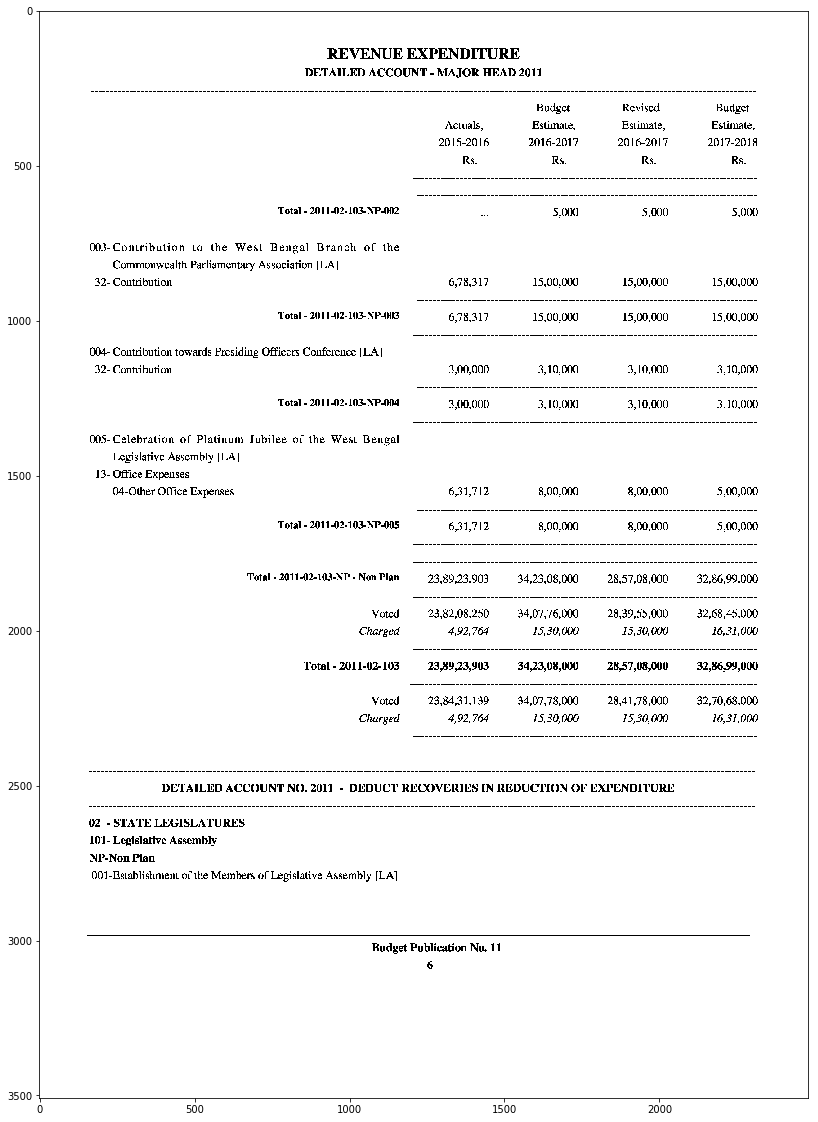

In [180]:
plot_page(img_page)

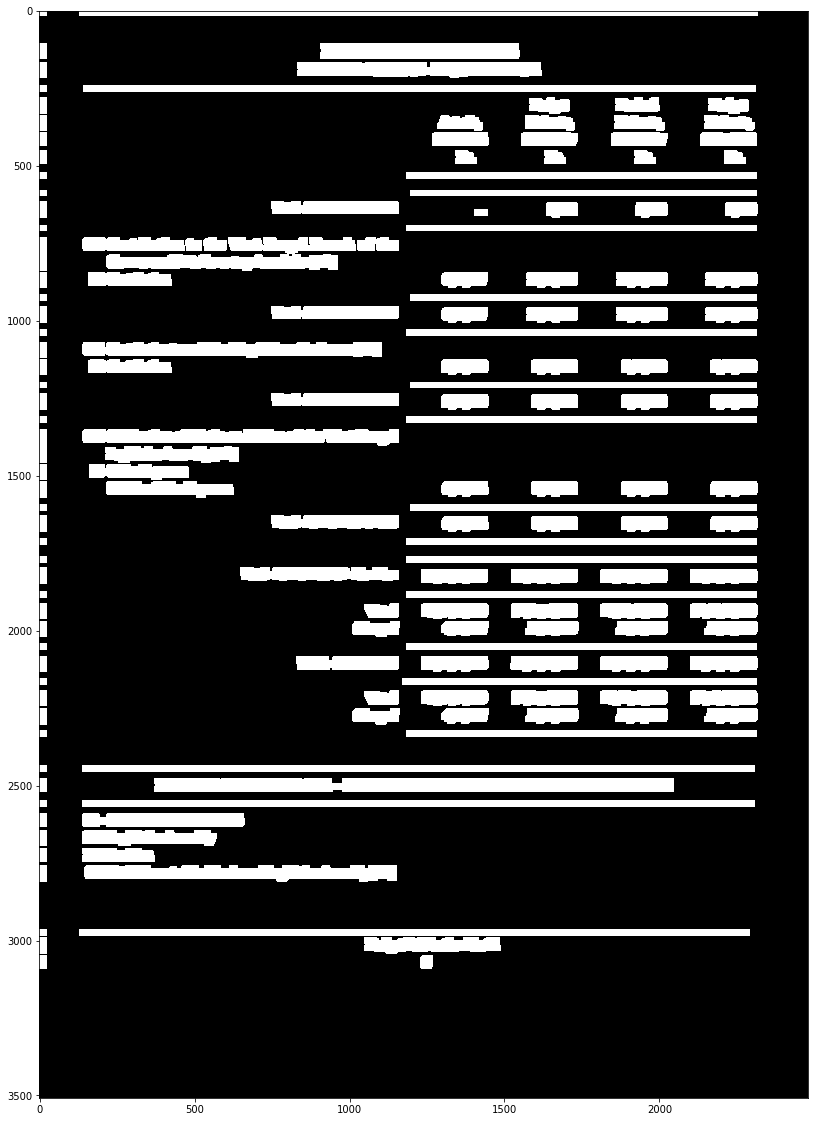

In [181]:
plot_page(feature_extractor.img_with_blocks)

In [ ]:
labeler = BlockLabeler(block_features)

In [ ]:
BlockLabeler(block_features, post_processors=[mark_tables_using_titles, 
                                                                           combine_headers,
                                                                           combine_horizontal]).label()

In [ ]:
block_features.apply(labeler.mark_title, axis=1, args=[])[['text', 'label', 'right']]

In [ ]:
block_features_with_labels[block_features_with_labels.table == 2]['row_index'].unique()

In [165]:
block_features_with_labels

,area,bottom,centroid_x,centroid_y,comma_separated_numbers_present,height,is_text,label,left,number,pos,possible_row_merger,right,table,text,text_length,top,width,row_index,col_index
4,34128.0,159.0,1226.833304,131.129249,0.0,54.0,1.0,title,906.0,NaN,4.0,0.0,1549.0,1.0,REVENUE EXPENDITURE,19.0,105.0,643.0,NaN,1.0
6,35613.0,218.0,1227.420240,191.262853,0.0,49.0,1.0,title,833.0,NaN,6.0,0.0,1622.0,1.0,DETAILED ACCOUNT - MAJOR HEAD 2013,34.0,169.0,789.0,NaN,1.0
10,5931.0,478.0,1644.686562,307.158827,0.0,196.0,1.0,header,1554.0,NaN,10.0,0.0,1738.0,1.0,"Budget Estimate, 2016-2017 Rs.",6.0,282.0,184.0,0.0,3.0
11,6180.0,470.0,1927.556472,305.665210,0.0,188.0,1.0,header,1843.0,NaN,11.0,0.0,2027.0,1.0,"Revised Estimate, 2016-2017 Rs.",7.0,282.0,184.0,0.0,4.0
12,5931.0,478.0,2222.686562,307.158827,0.0,196.0,1.0,header,2132.0,NaN,12.0,0.0,2316.0,1.0,"Budget Estimate, 2017-2018 Rs.",6.0,282.0,184.0,0.0,5.0
14,6010.0,480.0,1357.266556,363.256073,0.0,142.0,1.0,header,1266.0,NaN,14.0,0.0,1450.0,1.0,"Actuals, 2015-2016 Rs.",8.0,338.0,184.0,0.0,2.0
31,11667.0,609.0,289.303763,586.624496,0.0,46.0,1.0,grouping,157.0,NaN,31.0,0.0,430.0,1.0,32- Contribution,16.0,563.0,273.0,1.0,0.0
32,9513.0,614.0,1348.922632,586.613266,1.0,51.0,0.0,number_values,1251.0,80000000.0,32.0,0.0,1450.0,1.0,"8,00,00,000",11.0,563.0,199.0,1.0,2.0
33,9489.0,614.0,1638.036253,586.644536,1.0,51.0,0.0,number_values,1540.0,87200000.0,33.0,0.0,1739.0,1.0,"8,72,00,000",11.0,563.0,199.0,1.0,3.0
34,9489.0,614.0,1927.021709,586.644536,1.0,51.0,0.0,number_values,1829.0,87200000.0,34.0,0.0,2028.0,1.0,"8,72,00,000",11.0,563.0,199.0,1.0,4.0


-------

## TODO

Do column separation post getting alignment from each row

Possible Solution

    - Group rows by number of blocks
    - Sort by frequency
    - Calculate alignment for each block based on voting.
    
Do Feature Extraction from titles to generate names for csv file
Use the naming structure to combine csv files.
The Goal is for west bengal Demand No and Head is unique and each csv file should be unique with respect to it.

Handle Tables without headers.

Exclude tables with voted charged summaries

-----
## Glossary

#### RLSA
The Run Length Smoothing Algorithm (RLSA) is a method that can be used for Block segmentation and text discrimination. The method developed for the Document Analysis System consists of two steps. First, a segmentation procedure subdivides the area of a document into regions (blocks), each of which should contain only one type of data (text, graphic, halftone image, etc.). Next, some basic features of these blocks are calculated.

The basic RLSA is applied to a binary sequence in which white pixels are represented by 0’s and black pixels by 1’s. The algorithm transforms a binary sequence x into an output sequence y according to the following rules:

    0’s in x are changed to 1’s in y if the number of adjacent 0’s is less than or equal to a predefined limit C.
    1’s in x are unchanged in y .

For example, with C = 4 the sequence x is mapped into y as follows:

    x : 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0
    y : 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1